In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from datetime import datetime
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import boxcox
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind

# Passo 1 - Importar os dados

In [2]:
#import data
Products=pd.read_excel("data/Products.xlsx")
Products.set_index('Cust_ID', inplace = True)
Products.head()

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts
Cust_ID,,,,,,
4,0,76,2024-02-19,248,37,6
5,0,75,2024-02-17,248,37,6
6,6,69,2024-02-15,215,34,5
9,36,71,2024-02-13,248,35,8
10,8,97,2024-02-15,204,34,5


In [3]:
#search duplicates
len(Products[Products.duplicated()])

510

There are 510 duplicates.  

However, there is no reason to exclude them when the feedback we get is that the data's integrity is of the highst quality and all IDs (common with other two datasets are unique. It could be a specific promotion, for example.

In [4]:
#confirm uniqueness of IDs
len(Products.index.unique())

4000

In [5]:
#make column names better with snake_case
Products.columns = Products.columns.str.lower().str.replace('&','_')
Products.columns

Index(['fitness_gym', 'hiking_running', 'last_purchase', 'teamgames',
       'outdooractivities', 'totalproducts'],
      dtype='object')

# Visualização de Característias básicas dos DF

In [6]:
Products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fitness_gym        4000 non-null   int64         
 1   hiking_running     4000 non-null   int64         
 2   last_purchase      4000 non-null   datetime64[ns]
 3   teamgames          4000 non-null   int64         
 4   outdooractivities  4000 non-null   int64         
 5   totalproducts      4000 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 347.8 KB


All value types seem correct. No null values.

In [7]:
Products.describe()

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts
count,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000
mean,32.020250,55.844750,2024-01-30 18:50:02.399999744,176.085000,33.602750,5.329500
min,0.000000,9.000000,2023-10-15 00:00:00,0.000000,28.000000,2.000000
25%,25.000000,38.000000,2024-01-20 00:00:00,121.000000,32.000000,4.000000
50%,31.000000,47.000000,2024-02-01 00:00:00,180.000000,33.000000,5.000000
75%,40.000000,66.000000,2024-02-13 00:00:00,230.000000,35.000000,6.000000
max,123.000000,464.000000,2024-02-29 00:00:00,1203.000000,42.000000,20.000000
std,14.469284,33.119109,NaN,69.964738,1.711483,1.515257


All features have median and mean values close together, suggesting gaussian distribution data.  

Let's confirm.

In [8]:
#check skewness of data
numeric=['fitness_gym', 'hiking_running', 'teamgames', 'outdooractivities', 'totalproducts']
Products[numeric].skew()

fitness_gym          0.346342
hiking_running       4.671687
teamgames            0.740859
outdooractivities    0.414896
totalproducts        1.791119
dtype: float64

hiking_running and totalproducts  are highly positively skewed.  
teamgames is moderately skewed.


In [9]:
Products[numeric].kurt()

fitness_gym           1.464810
hiking_running       37.839539
teamgames            10.605494
outdooractivities     0.399144
totalproducts         9.247286
dtype: float64

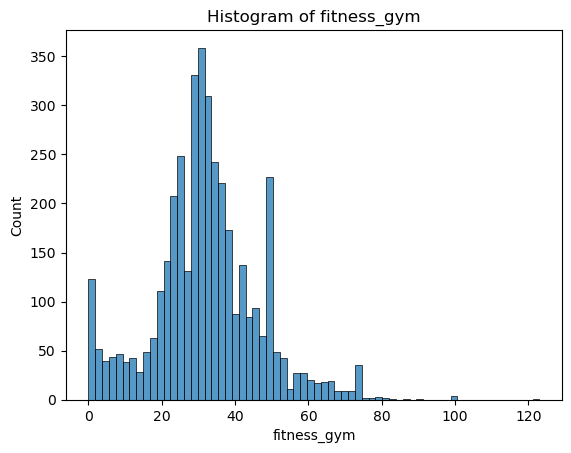

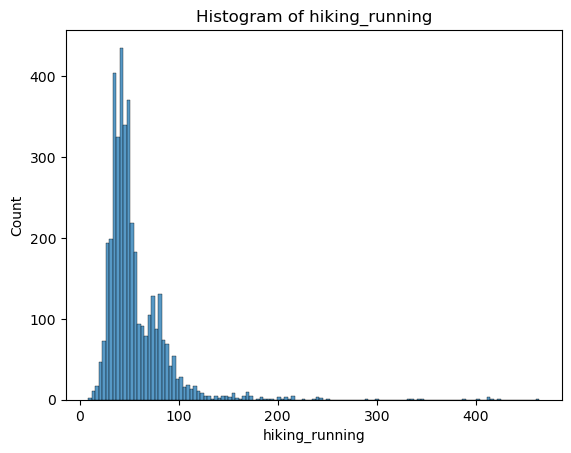

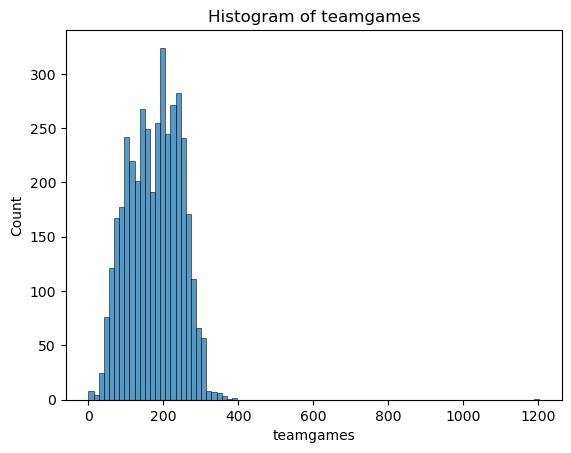

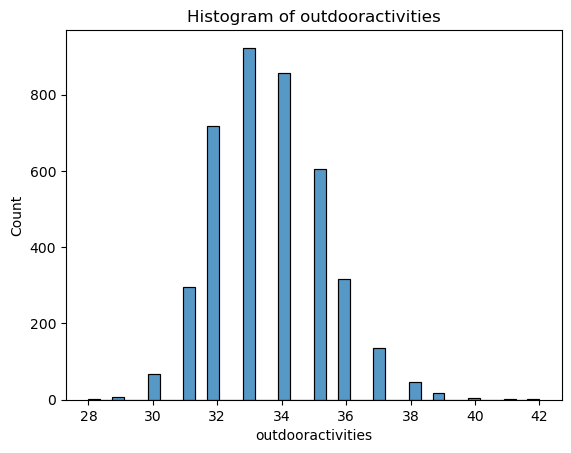

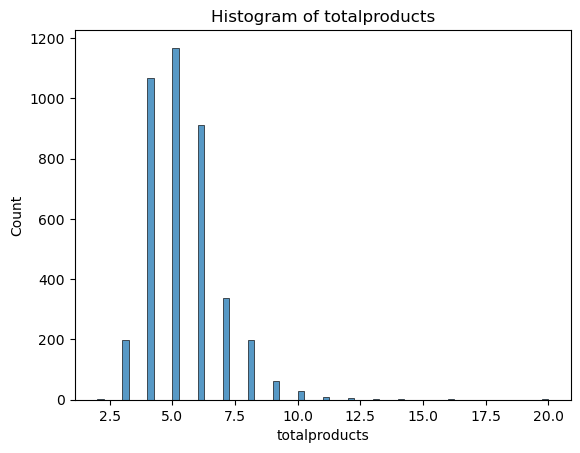

In [10]:
#check distributions
for column in Products[numeric].columns:
    sns.histplot(data=Products, x=column)
    plt.title(f'Histogram of {column}')
    plt.show()

# Step 2 - Preprocessing

No Df Products, criamos
1) Coluna de Total de Gasto,
2) Gasto médio por produto e
3) Trocamos data de última compra por #dias desde da última compra (assumindo 21-04-2024)
4) Removemos os duplicados
5) Deixar cair a coluna 'TotalProducts' porque não dá grande informação.

In [11]:
# Criar a nova coluna "Total_Expensed" com a soma das colunas especificadas
spending=['fitness_gym', 'hiking_running', 'teamgames', 'outdooractivities']
Products['total_spent'] = Products[spending].sum(axis=1)
Products.head()                                                   

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts,total_spent
Cust_ID,,,,,,,
4,0,76,2024-02-19,248,37,6,361
5,0,75,2024-02-17,248,37,6,360
6,6,69,2024-02-15,215,34,5,324
9,36,71,2024-02-13,248,35,8,390
10,8,97,2024-02-15,204,34,5,343


In [12]:
Products['Avg_Spent']=Products['total_spent']/Products['totalproducts']
Products['Avg_Spent'] = np.ceil(Products['Avg_Spent'])  # Arredondar para cima
Products['Avg_Spent']=Products['Avg_Spent'].astype(int)
Products.head()

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent
Cust_ID,,,,,,,,
4,0,76,2024-02-19,248,37,6,361,61
5,0,75,2024-02-17,248,37,6,360,60
6,6,69,2024-02-15,215,34,5,324,65
9,36,71,2024-02-13,248,35,8,390,49
10,8,97,2024-02-15,204,34,5,343,69


In [13]:
#get number of days since last purchase
Products['last_purchase'] = pd.to_datetime(Products['last_purchase'])
today = pd.Timestamp(datetime.today().date())  # ou pd.Timestamp('today')
Products['Days_Since_Last_Purchase'] = (today - Products['last_purchase']).dt.days
Products.drop('last_purchase', axis=1, inplace=True)
Products.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,,
4,0,76,248,37,6,361,61,67
5,0,75,248,37,6,360,60,69
6,6,69,215,34,5,324,65,71
9,36,71,248,35,8,390,49,73
10,8,97,204,34,5,343,69,71


## DEA

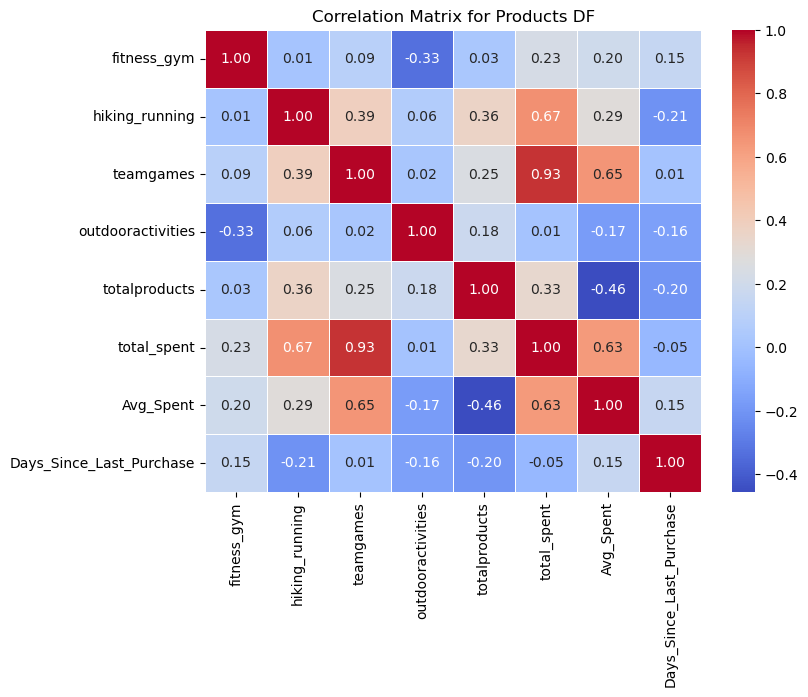

In [14]:
# Calcular a matriz de correlação
correlation_matrix_Products = Products.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_Products, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Products DF')
plt.show() #Vejo correlação mt forte entre Total_Expensed e TeamGames

No high correlations, except 'teamgames' vs 'total_spent', since teamgames influence highly the amount spent due to the high values involved.

# Scaling

In [15]:
#scaling
scaler = StandardScaler()
Products_scaled = pd.DataFrame(scaler.fit_transform(Products), columns = Products.columns) #applied to all columns because all are numeric
Products_scaled = Products_scaled.drop('total_spent', axis=1) #because of high correlation to teamgames
Products_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase
0,-2.213258,0.608645,1.028003,1.985222,0.442555,0.122862,-1.124793
1,-2.213258,0.578447,1.028003,1.985222,0.442555,0.069922,-1.007720
2,-1.798534,0.397260,0.556278,0.232138,-0.217482,0.334626,-0.890647
3,0.275083,0.457656,1.028003,0.816499,1.762628,-0.512427,-0.773574
4,-1.660293,1.242799,0.399037,0.232138,-0.217482,0.546389,-0.890647


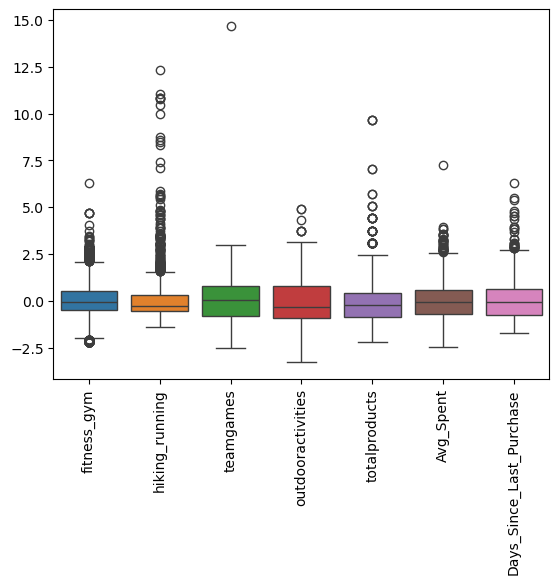

In [16]:
#check data variability
sns.boxplot(data=Products_scaled)
plt.xticks(rotation=90)
plt.show() 

One clear outlier in teamgames, which may impact the skewness of the distribution.

### Delete outlier and rerun scaling

In [17]:
#get IDs
ids = Products.index

In [18]:
#assign IDs innscaled df
Products_scaled.index= ids

In [19]:
#check oultier
index = Products_scaled['teamgames'].idxmax()
index

4380

In [20]:
#exclude outlier in original dataframe
Products = Products.drop(index, axis=0)
len(Products)

3999

In [21]:
#rerun scaling
scaler = StandardScaler()
Products_scaled = pd.DataFrame(scaler.fit_transform(Products), columns = Products.columns) #applied to all columns because all are numeric
Products_scaled = Products_scaled.drop('total_spent', axis=1) #because of high correlation to teamgames
Products_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase
0,-2.213533,0.608729,1.060514,1.985344,0.442842,0.125497,-1.125215
1,-2.213533,0.578533,1.060514,1.985344,0.442842,0.072209,-1.008132
2,-1.798667,0.397362,0.575602,0.232332,-0.217212,0.338647,-0.891049
3,0.275661,0.457753,1.060514,0.816669,1.762951,-0.513953,-0.773966
4,-1.660379,1.242827,0.413965,0.232332,-0.217212,0.551797,-0.891049


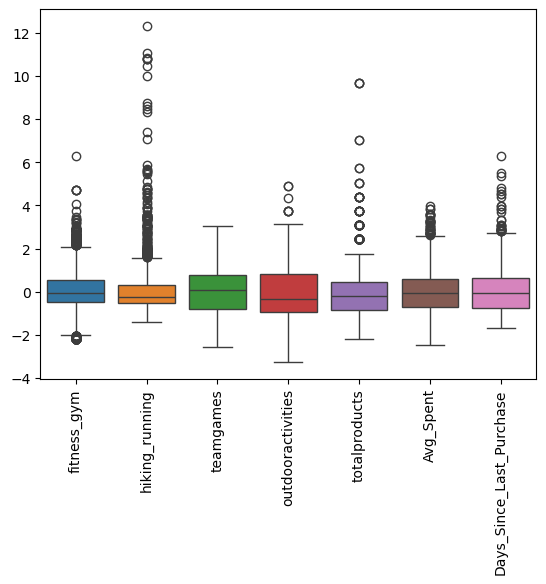

In [22]:
#check data variability
sns.boxplot(data=Products_scaled)
plt.xticks(rotation=90)
plt.show()

array([[<Axes: title={'center': 'fitness_gym'}>,
        <Axes: title={'center': 'hiking_running'}>,
        <Axes: title={'center': 'teamgames'}>],
       [<Axes: title={'center': 'outdooractivities'}>,
        <Axes: title={'center': 'totalproducts'}>,
        <Axes: title={'center': 'total_spent'}>],
       [<Axes: title={'center': 'Avg_Spent'}>,
        <Axes: title={'center': 'Days_Since_Last_Purchase'}>, <Axes: >]],
      dtype=object)

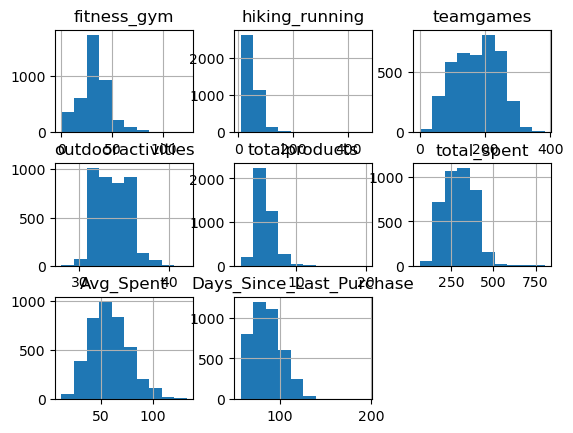

In [23]:
Products.hist()

In [24]:
Products.skew()

fitness_gym                 0.346426
hiking_running              4.672001
teamgames                  -0.043263
outdooractivities           0.415424
totalproducts               1.792204
total_spent                 0.442798
Avg_Spent                   0.478345
Days_Since_Last_Purchase    0.715239
dtype: float64

### Hiking_running

In [25]:
# Applying Transformations to hiking_running
hiking_running_log = np.log(Products.hiking_running)
hiking_running_sqrt = np.sqrt(Products.hiking_running)
hiking_running_cbrt = np.cbrt(Products.hiking_running)

print(f'Skewness of original data: {Products.hiking_running.skew():.5f}')
print(f'Skewness after Log Transformation: {hiking_running_log.skew():.5f}')
print(f'Skewness after Square Root Transformation: {hiking_running_sqrt.skew():.5f}')
print(f'Skewness after Cubic Root Transformation: {hiking_running_cbrt.skew():.5f}')

Skewness of original data: 4.67200
Skewness after Log Transformation: 0.79044
Skewness after Square Root Transformation: 2.17065
Skewness after Cubic Root Transformation: 1.62253


In [26]:
# Applying Box-Cox Transformation after checking all values are positive
if (Products.hiking_running > 0).all(): #needs all values to be positive
    hiking_running_boxcox, _ = boxcox(Products.hiking_running)
    hiking_running_boxcox = pd.Series(hiking_running_boxcox)
else:
    # Consider alternative transformations or handling strategies
    print("Not all SalePrice values are positive. Consider using Yeo-Johnson or handling negative values.")
print(f"Skewness after Box-Cox Transformation: {hiking_running_boxcox.skew():.5f}")

Skewness after Box-Cox Transformation: -0.05384


<Axes: >

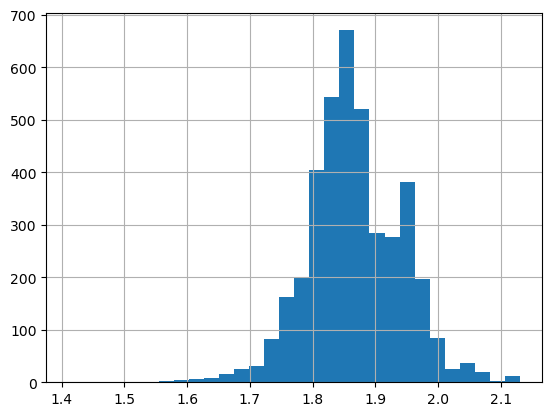

In [27]:
#check box cox transform
hiking_running_boxcox.hist(bins=30)

<Axes: >

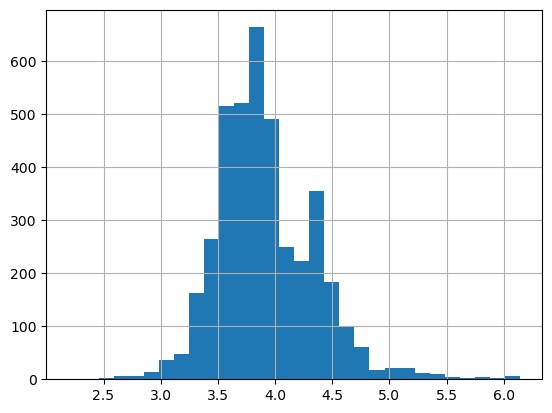

In [28]:
#check log transform
hiking_running_log.hist(bins=30)

Similar. Box Cox transform is better: lower skewness value.
However Box Cox insert empty values to df, so we will use Log method.

In [29]:
#apply to original dataset
Products_trans = Products.copy()
Products_trans.hiking_running = hiking_running_log

### totalproducts

In [30]:
# Applying Transformations to hiking_running
totalproducts_log = np.log(Products.totalproducts)
totalproducts_sqrt = np.sqrt(Products.totalproducts)
totalproducts_cbrt = np.cbrt(Products.totalproducts)

print(f'Skewness of original data: {Products.totalproducts.skew():.5f}')
print(f'Skewness after Log Transformation: {totalproducts_log.skew():.5f}')
print(f'Skewness after Square Root Transformation: {totalproducts_sqrt.skew():.5f}')
print(f'Skewness after Cubic Root Transformation: {totalproducts_cbrt.skew():.5f}')

Skewness of original data: 1.79220
Skewness after Log Transformation: 0.31477
Skewness after Square Root Transformation: 0.90738
Skewness after Cubic Root Transformation: 0.68858


De novo, Log apresenta boa transformação levando a um skewness reduzido.

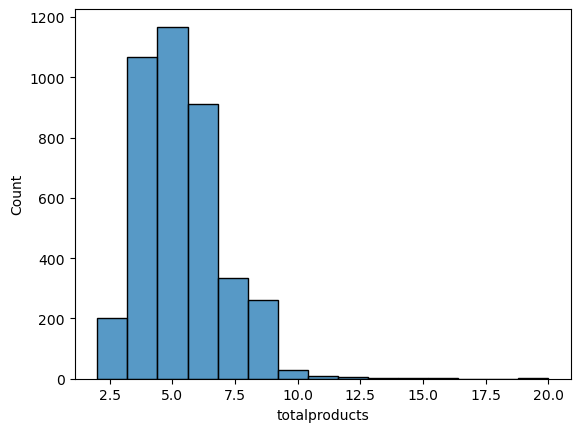

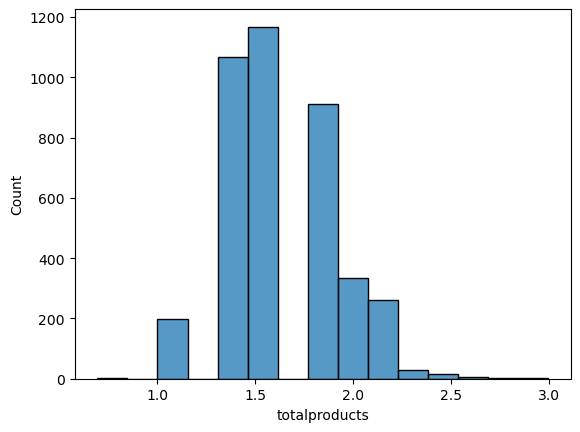

In [31]:
sns.histplot(Products.totalproducts, bins=15)
plt.show()
sns.histplot(totalproducts_log, bins=15)
plt.show()

In [32]:
#transform df
Products_trans.totalproducts = totalproducts_log

## New scaling on transformed data

In [33]:
#rerun scaling
scaler = StandardScaler()
Products_trans_scaled = pd.DataFrame(scaler.fit_transform(Products_trans), columns = Products_trans.columns) #applied to all columns because all are numeric
Products_trans_scaled = Products_trans_scaled.drop('total_spent', axis=1) #because of high correlation to teamgames
Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase
0,-2.213533,0.965928,1.060514,1.985344,0.586760,0.125497,-1.125215
1,-2.213533,0.934989,1.060514,1.985344,0.586760,0.072209,-1.008132
2,-1.798667,0.740221,0.575602,0.232332,-0.106751,0.338647,-0.891049
3,0.275661,0.806964,1.060514,0.816669,1.681040,-0.513953,-0.773966
4,-1.660379,1.535826,0.413965,0.232332,-0.106751,0.551797,-0.891049


In [34]:
Products_trans_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fitness_gym               3999 non-null   float64
 1   hiking_running            3999 non-null   float64
 2   teamgames                 3999 non-null   float64
 3   outdooractivities         3999 non-null   float64
 4   totalproducts             3999 non-null   float64
 5   Avg_Spent                 3999 non-null   float64
 6   Days_Since_Last_Purchase  3999 non-null   float64
dtypes: float64(7)
memory usage: 218.8 KB


# kmeans clustering

C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1538, in _execute_child


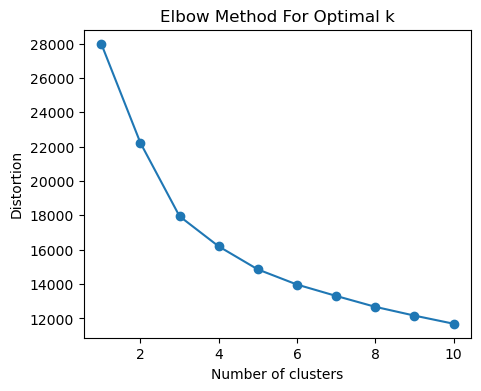

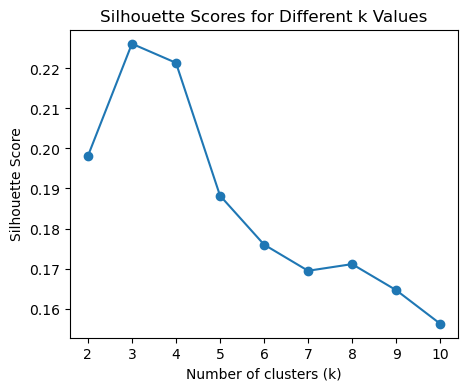

In [35]:
# Calculate distortion for a range of number of cluster
distortions = [] #for elbow method

#for silhouette method
features = Products_trans_scaled
silhouette_scores = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels = km.fit_predict(features)  # Fit and predict simultaneously
    #calculate inertia score
    distortions.append(km.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

### Conclusion on clusters
- elbow method not clear on the best number of cluster with a smooth curve
- silhuette method suggests 3 clusters, followed by 4, then by 2.

We will get **3** clusters first. Depending on difficulties in interpreting the data, we may go to 2.

In [42]:
#save model and assign clusters
n_clusters=3
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km.fit(Products_trans_scaled) #create model
clusters = km.labels_ #assign clusters

### Assigning labels to datasets

In [44]:
#Products original (menos outlier)
Products['cluster_label']= clusters #assign clusters to df
Products.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase,cluster_label
Cust_ID,,,,,,,,,
4,0,76,248,37,6,361,61,67,1
5,0,75,248,37,6,360,60,69,1
6,6,69,215,34,5,324,65,71,1
9,36,71,248,35,8,390,49,73,1
10,8,97,204,34,5,343,69,71,1


In [45]:
#Products transformed e scaled
Products_trans_scaled['cluster_label']=clusters
Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase,cluster_label
0,-2.213533,0.965928,1.060514,1.985344,0.586760,0.125497,-1.125215,1
1,-2.213533,0.934989,1.060514,1.985344,0.586760,0.072209,-1.008132,1
2,-1.798667,0.740221,0.575602,0.232332,-0.106751,0.338647,-0.891049,1
3,0.275661,0.806964,1.060514,0.816669,1.681040,-0.513953,-0.773966,1
4,-1.660379,1.535826,0.413965,0.232332,-0.106751,0.551797,-0.891049,1


# Export DFs

In [46]:
#export final df with original cleaned data and a column with clusters
Products.to_csv('exported_data/Product_clustered.csv', index=True) #includes indices

#then import with:
#pd.read_csv('exported_data/Product_clustered.csv', index_col=0)

# Clusters analysis

In [47]:
Products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 4 to 6496
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   fitness_gym               3999 non-null   int64
 1   hiking_running            3999 non-null   int64
 2   teamgames                 3999 non-null   int64
 3   outdooractivities         3999 non-null   int64
 4   totalproducts             3999 non-null   int64
 5   total_spent               3999 non-null   int64
 6   Avg_Spent                 3999 non-null   int32
 7   Days_Since_Last_Purchase  3999 non-null   int64
 8   cluster_label             3999 non-null   int32
dtypes: int32(2), int64(7)
memory usage: 281.2 KB


In [51]:
#count entries in each cluster
Products.groupby('cluster_label').cluster_label.count().transpose()

cluster_label
0    1244
1    1139
2    1616
Name: cluster_label, dtype: int64

In [52]:
#look at means
Products.groupby('cluster_label').mean().transpose()

cluster_label,0,1,2
fitness_gym,37.489550,26.718174,31.529703
hiking_running,54.255627,82.598771,38.199876
teamgames,218.150322,220.545215,111.730817
outdooractivities,32.767685,34.742757,33.441213
totalproducts,4.553055,6.503951,5.098391
total_spent,342.663183,364.604917,214.901609
Avg_Spent,77.412379,58.303775,44.438119
Days_Since_Last_Purchase,98.104502,73.377524,86.125000


Análise dos 3 clusters em curso 

1244, 1139, 1616 – boa divisão 

0 – gasta mais em 

- Fitness 

- Demora mais a retornar (98 dias) (Days_Since_Last_Purchase) 

1 – gasta mais em 

- Hiking 

- Retorna em 73 dias (Days_Since_Last_Purchase) 

2 – gasta menos dinheiro em tudo 

### Days_Since_Last_Purchase

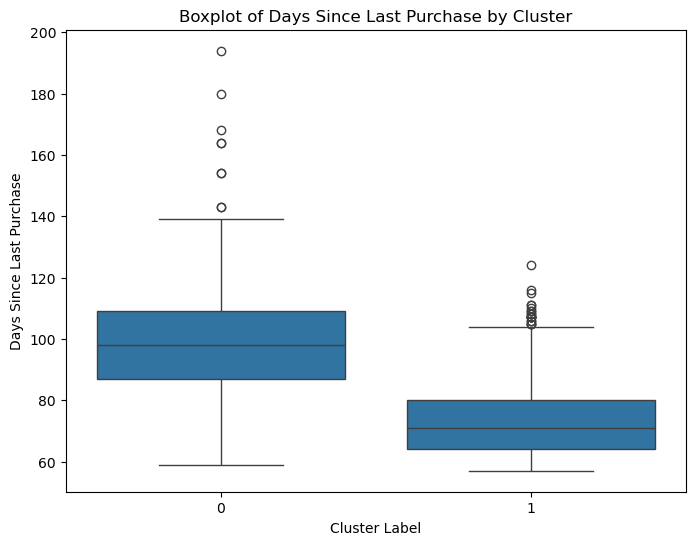

In [61]:
#Products.query("cluster_label == 0")['Days_Since_Last_Purchase'].plot())

# Filtering data for cluster_label == 0
data = Products[Products['cluster_label'].isin([0, 1])]

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='cluster_label', y='Days_Since_Last_Purchase')
plt.title('Boxplot of Days Since Last Purchase by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Days Since Last Purchase')
plt.show()


In [69]:
#statistics
feature = 'Days_Since_Last_Purchase'
# Extracting data for each cluster
cluster_0_data = Products.query("cluster_label == 0")[feature]
cluster_1_data = Products.query("cluster_label == 1")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_1_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 43.112860485168966
P-value: 4.293859867795627e-295


**They are statistically significant**

### fitness_gym

In [70]:
#statistics
feature = 'fitness_gym'
# Extracting data for each cluster
cluster_0_data = Products.query("cluster_label == 0")[feature]
cluster_1_data = Products.query("cluster_label == 1")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_1_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 16.231926246803713
P-value: 4.572323850316848e-56


**fitness_gym is statistically different**

### hiking_running

In [71]:
#statistics
feature = 'hiking_running'
# Extracting data for each cluster
cluster_0_data = Products.query("cluster_label == 0")[feature]
cluster_1_data = Products.query("cluster_label == 1")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_1_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -19.378457449425557
P-value: 1.3709962065858575e-76


**hiking_running is statistically different**